In [1]:
from numpy.random import default_rng
import scanpy as sc
# import squidpy as sq
from anndata import AnnData
import scipy
# sc.logging.print_header()
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import pandas as pd
import seaborn as sns
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
from sklearn.metrics.cluster import normalized_mutual_info_score, homogeneity_score, completeness_score

In [3]:
from scipy.spatial import cKDTree
from scipy.stats import mode
def cKD_refine_label(coords, labels, k):
    # Step 1: Build KD-Tree
    tree = cKDTree(coords.copy())

    # Step 2: Find k-nearest neighbors for each spot
    # k+1 because the closest point is itself
    distances, neighbors = tree.query(coords, k=k+1)

    # Exclude self-neighbor (first column)
    neighbors = neighbors[:, 1:]

    # Step 3: Reassign labels
    new_labels = labels.copy()
    for i, nbrs in enumerate(neighbors):
        # Get the labels of neighboring spots
        neighbor_labels = labels[nbrs]
        # Find the most common label among neighbors
        most_common_label = mode(neighbor_labels, keepdims=True).mode[0]
        # Reassign the label
        new_labels[i] = most_common_label
    return (new_labels)

In [5]:
# %load_ext autoreload
# %autoreload 2
%unload_ext autoreload

The autoreload extension is not loaded.


In [7]:
slice_id = 'SpatialGlue'
adata=sc.read_h5ad('/Users/melancholy/Desktop/SpatialGlue/Adata_all/adata_all_human_lymph_node_A1.h5ad')
file_pickle = 'Data/'+slice_id+'.pickle'

In [5]:
# adata.obsm['RNA_feat'], adata.obsm['Pro_feat'], adata.obsm['spatial'] 

In [9]:
true_annotation = pd.read_csv("/Users/melancholy/Desktop/SpatialGlue/annotation.csv")

In [11]:
true_annotation.replace('medulla sinuses', 'medulla', inplace = True)
true_annotation.replace('medulla cords', 'medulla', inplace = True)
true_annotation.replace('medulla vessels', 'medulla', inplace = True)

In [13]:
df_spatial = pd.DataFrame(adata.obsm['spatial'])
true_labels = pd.factorize(true_annotation['manual-anno'])[0]
df_spatial['region'] = true_annotation['manual-anno']
df_spatial['origi'] = pd.factorize(adata.obs['label_new'])[0]
df_spatial.columns = ['x', 'y', 'region', 'origi']

In [15]:
if np.min(true_labels) >= 0:
    n_clusters = len(np.unique(true_labels))
else:
    n_clusters = len(np.unique(true_labels)) - 1
n_clusters

8

## Data analysis

In [17]:
from sklearn.decomposition import PCA
# from GraphST.utils import refine_label
from sklearn.preprocessing import StandardScaler
# from GraphST.utils import mclust_R
import numpy as np
from numpy import dot, array
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

In [19]:
embedding = adata.obsm['RNA_feat']
n_neighbors = 3
connectivity = kneighbors_graph(adata.obsm['spatial'], n_neighbors=n_neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)
embedding_RNA = connectivity.dot(embedding)

embedding = adata.obsm['Pro_feat']
connectivity = kneighbors_graph(adata.obsm['spatial'], n_neighbors=n_neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)
embedding_Pro = connectivity.dot(embedding)

pca = PCA(n_components=2, random_state=42) 
RNA_pca_embedding = pca.fit_transform(embedding_RNA)

pca = PCA(n_components=2, random_state=42) 
Pro_pca_embedding = pca.fit_transform(embedding_Pro)

# Standardize the data
scaler_a = StandardScaler()
scaler_b = StandardScaler()

data_a_train = scaler_a.fit_transform(embedding_RNA)
data_b_train = scaler_b.fit_transform(embedding_Pro)

# Define and train the CCA model
n_components = 5  # Number of canonical components
cca = CCA(n_components=n_components)
cca.fit(data_a_train, data_b_train)

#adata.obsm['emb_pca'] = np.concatenate((embedding_RNA/np.linalg.norm(embedding_RNA), embedding_Pro), axis=1)

CCA(n_components=5)

In [30]:
from sklearn.mixture import BayesianGaussianMixture
from mvlearn.datasets import load_UCImultifeature
from mvlearn.embed import GCCA

from mvlearn.plotting import crossviews_plot
from mvlearn.embed import DCCA
from mvlearn.embed import MCCA
from mvlearn.embed import KMCCA

Xs = [data_a_train-data_a_train.min(), data_b_train-data_b_train.min()] # multiview data
for n_components in range(10,52,20):
    for covariance_type in ['full']: #, 'tied'
        #for kernel in ['chi2', 'linear', 'poly','rbf', 'laplacian']:
        for kernel in ['poly']:
            for regs in [1]:
                print(n_components, covariance_type, kernel, regs)
                mcca = KMCCA(n_components = n_components, kernel = kernel, regs = regs)
                mcca.fit(Xs)
                # MCCA()
                Xs_latents = mcca.transform(Xs)
                adata.obsm['emb_pca'] = np.concatenate((Xs_latents[0,:,:], Xs_latents[1,:,:]), axis=1)
                gmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type=covariance_type, random_state=42, init_params = 'random_from_data', n_init = 5, max_iter = 1000)

                # Step 4: Fit GMM
                gmm.fit(adata.obsm['emb_pca'])
                cluster_labels = gmm.predict(adata.obsm['emb_pca'])
                adata.obs['domain'] = cluster_labels
                print(adjusted_rand_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0]))
                print(normalized_mutual_info_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0]))
                print(homogeneity_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0]))
                print(completeness_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0]))

10 full poly 1
0.4497853606842567
0.38255585392530284
0.42303878070429557
0.34914429978812916
30 full poly 1
0.31215281078643103
0.2802551739571993
0.2795082500491278
0.28100610053904307
50 full poly 1
0.137702804219772
0.17818137047156585
0.11073308449184288
0.4558314565279915


In [21]:
### SOTA
n_clusters = 6
from sklearn.mixture import BayesianGaussianMixture
from mvlearn.datasets import load_UCImultifeature
from mvlearn.embed import GCCA
# gcca = GCCA(n_components = 20)
# Xs_latents = gcca.fit_transform(Xs)

from mvlearn.plotting import crossviews_plot
from mvlearn.embed import DCCA
from mvlearn.embed import MCCA
from mvlearn.embed import KMCCA


Xs = [data_a_train-data_a_train.min(), data_b_train-data_b_train.min()] # multiview data

mcca = KMCCA(n_components = 10, kernel = 'poly', regs = 1)
mcca.fit(Xs)

Xs_latents = mcca.transform(Xs)
adata.obsm['emb_pca'] = np.concatenate((Xs_latents[0,:,:], Xs_latents[1,:,:]), axis=1)
gmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42, init_params = 'random_from_data', n_init = 5, max_iter = 1000)

# Step 4: Fit GMM
gmm.fit(adata.obsm['emb_pca'])
cluster_labels = gmm.predict(adata.obsm['emb_pca'])
adata.obs['domain'] = cluster_labels

print(adjusted_rand_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0]))
print(normalized_mutual_info_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0]))
print(homogeneity_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0]))
print(completeness_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0]))

0.5851806059445155
0.4447309673712676
0.4649118665524078
0.4262292055449938


In [22]:
print(adjusted_rand_score(true_annotation['manual-anno'], adata.obs['SpatialGlue']))
print(normalized_mutual_info_score(true_annotation['manual-anno'], adata.obs['SpatialGlue']))
print(homogeneity_score(true_annotation['manual-anno'], adata.obs['SpatialGlue']))
print(completeness_score(true_annotation['manual-anno'], adata.obs['SpatialGlue']))

0.34306668778464056
0.40900974844363924
0.4552992955722765
0.3712639406926021


In [23]:
df_spatial['GraphBGM-multi'] = list(adata.obs['domain'].values)
df_spatial['SpatialGlue'] = list(adata.obs['SpatialGlue'].values)

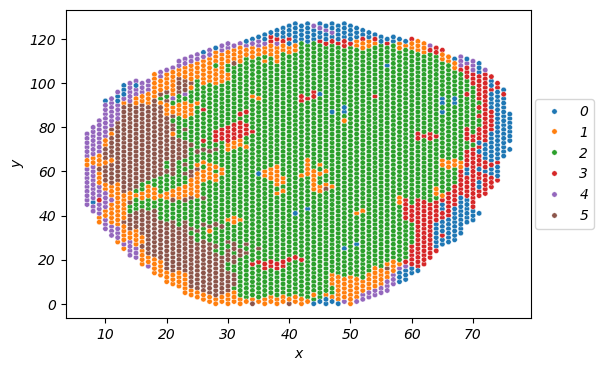

In [66]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 1, figsize=(6, 4))
ax = sns.scatterplot(x="x", y="y", hue = 'GraphBGM-multi',s = 15,  data=df_spatial, palette="tab10")
ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1)
plt.show()

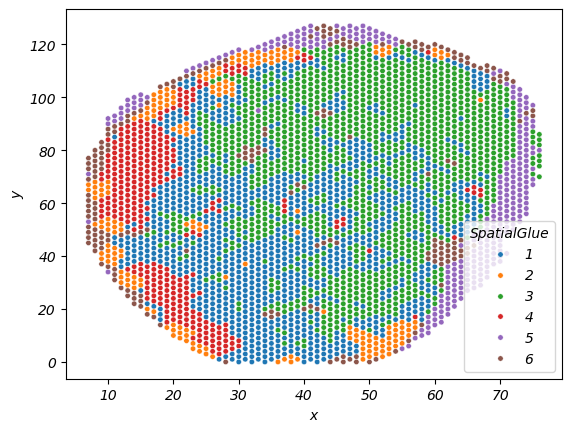

In [68]:
ax = sns.scatterplot(x="x", y="y", hue = 'SpatialGlue',s = 15,  data=df_spatial, palette="tab10")

In [24]:
ari_bgm = adjusted_rand_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0])
nmi_bgm = normalized_mutual_info_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0])
hom_bgm = homogeneity_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0])
com_bgm = completeness_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0])

ari_sg = adjusted_rand_score(true_annotation['manual-anno'], adata.obs['SpatialGlue'])
nmi_sg = normalized_mutual_info_score(true_annotation['manual-anno'], adata.obs['SpatialGlue'])
hom_sg = homogeneity_score(true_annotation['manual-anno'], adata.obs['SpatialGlue'])
com_sg = completeness_score(true_annotation['manual-anno'], adata.obs['SpatialGlue'])

data = {
    "Method": ["GraphBGM", "SpatialGlue"],
    "homogeneity": [hom_bgm, hom_sg],
    "completeness": [com_bgm, com_sg],
    "NMI": [nmi_bgm, nmi_sg],
    "ARI": [ari_bgm, ari_sg]
}

df = pd.DataFrame(data)

# Lưu thành file CSV
output_path = "human_metrics_results.csv"
df.to_csv(output_path, index=False)